In [290]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

import os
from utils import COLUMNS_NAME, cliff_delta, compute_features_deviations, compute_classification_performance

import warnings
warnings.simplefilter("ignore")

## Paths

In [291]:
version = 'v1'

In [292]:
datasets_path = '../../data/datasets/'
dataset_name = 'test_dataset'
dataset_path = datasets_path + dataset_name + '.csv'

In [293]:
# ----------------------------------------------------------------------------
model_name = 'supervised_vae'

bootstrap_dir = '../../outputs/' + model_name + '/bootstrap_ids/'
model_dir = bootstrap_dir + version + '/' 

In [294]:
normal_label = 0 #0: not graduate on time
abnormal_label = 1 #1: graduate on time

## Load data

In [295]:
#Loading data
test_df = pd.read_csv(dataset_path)
test_df.tail()

,IDX_STUDENT,COD_PROGRAMA,JORNADA,DURACION,PERIODO_INGRESO,SEXO,ESTADO_CIVIL,ESTRATO,RANGO_EDAD,CONDICION_EXCEPCION,...,RANGO_INGRESOS,RANGO_GASTOS,TIPO_VIVIENDA,PUNTAJE_ICFES,PCN,PLC,PMA,PSC,PIN,GRADUADO_A_TIEMPO
343,STUDENT_1648,2710,2,7,7,1,1,2,3,1,...,4,4,2,223,45,48,51,46,33,1
344,STUDENT_1746,2710,2,7,5,1,1,3,2,1,...,2,2,2,277,60,47,60,55,55,1
345,STUDENT_1750,2710,2,7,5,1,1,1,4,1,...,2,2,4,298,57,59,64,69,48,1
346,STUDENT_1773,2710,2,7,5,1,1,3,2,1,...,2,2,2,242,56,46,49,41,50,1
347,STUDENT_1873,2710,1,6,2,1,1,2,3,1,...,2,2,2,236,48,53,60,44,31,1


## Iter bootstrap

In [296]:
n_bootstrap = 10

In [297]:
tpr_list = []
auc_roc_list = []
effect_size_list = []

#file_name = '{}_vs_{}'.format(normal_label, disease_label)

In [298]:
name_id_label = 'IDX_STUDENT'
name_var_target = 'GRADUADO_A_TIEMPO'
normal_label = 0 #0: not graduate on time
abnormal_label = 1

In [299]:
for i_bootstrap in tqdm(range(n_bootstrap)):
    bootstrap_model_dir = model_dir + '{:03d}'.format(i_bootstrap)
    
    output_dataset_dir = bootstrap_model_dir + '/outputs/'
     
    # ----------------------------------------------------------------------------
    
    normalized_df = pd.read_csv(output_dataset_dir + 'normalized.csv', index_col=name_id_label)
    reconstruction_df = pd.read_csv(output_dataset_dir + 'reconstruction.csv', index_col=name_id_label)
    reconstruction_error_df = pd.read_csv(output_dataset_dir + 'reconstruction_error.csv', index_col=name_id_label)

    # ----------------------------------------------------------------------------
    # Compute effect size of the brain regions for the bootstrap iteration
    diff_df = np.abs(normalized_df - reconstruction_df)
    region_df = compute_features_deviations(diff_df, test_df, name_id_label, name_var_target, normal_label, abnormal_label)
    effect_size_list.append(region_df['effect_size'].values)
    region_df.to_csv(output_dataset_dir + 'regions_analysis.csv', index=False)
    
    # ----------------------------------------------------------------------------
    # Compute AUC-ROC for the bootstrap iteration
    roc_auc, tpr = compute_classification_performance(reconstruction_error_df, test_df, 
                                                      name_id_label, name_var_target, normal_label, abnormal_label)
    auc_roc_list.append(roc_auc)
    tpr_list.append(tpr)

100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


## Save results

In [300]:
comparison_dir = '../../outputs/' + model_name + '/comparison/' + version + '/' 

if not os.path.exists(comparison_dir):
    os.mkdir(comparison_dir)

In [301]:
# ----------------------------------------------------------------------------
# Save regions effect sizes
effect_size_df = pd.DataFrame(columns=COLUMNS_NAME, data=np.array(effect_size_list))
effect_size_df.to_csv(comparison_dir  + 'effect_size.csv')

In [302]:
# Save AUC bootstrap values
auc_roc_list = np.array(auc_roc_list)
auc_roc_df = pd.DataFrame(columns=['AUC-ROC'], data=auc_roc_list)
auc_roc_df.to_csv(comparison_dir  + 'auc_rocs.csv', index=False)

## Plot figures

In [303]:
# ----------------------------------------------------------------------------
# Create Figure 3 of the paper
tpr_list = np.array(tpr_list)
mean_tprs = tpr_list.mean(axis=0)
tprs_upper = np.percentile(tpr_list, 97.5, axis=0)
tprs_lower = np.percentile(tpr_list, 2.5, axis=0)

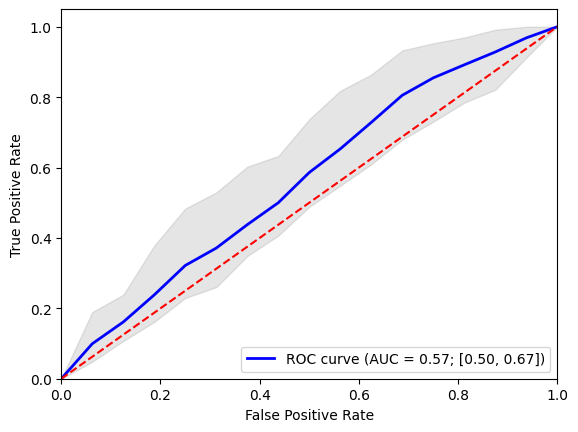

In [304]:
plt.plot(np.linspace(0, 1, len(COLUMNS_NAME)),
             mean_tprs,
             'b', lw=2,
             label='ROC curve (AUC = {:0.2f}; [{:0.2f}, {:0.2f}])'.format(np.mean(auc_roc_list),
                                                                                  np.percentile(auc_roc_list, 2.5),
                                                                                  np.percentile(auc_roc_list, 97.5)))

plt.fill_between(np.linspace(0, 1, len(COLUMNS_NAME)),
                     tprs_lower, tprs_upper,
                     color='grey', alpha=0.2)

plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.savefig(comparison_dir  + 'AUC-ROC.png', format='png')
#plt.close()
#plt.clf()

In [305]:
 # --------------------------------------------------------------------------------------------
# Create figure for supplementary materials
effect_size_df = effect_size_df.reindex(effect_size_df.mean().sort_values().index, axis=1)

plt.figure(figsize=(16, 20))
plt.hlines(range(len(COLUMNS_NAME)),
               np.percentile(effect_size_df, 2.5, axis=0),
               np.percentile(effect_size_df, 97.5, axis=0))

plt.plot(effect_size_df.mean().values, range(len(COLUMNS_NAME)), 's', color='k')
plt.axvline(0, ls='--')
plt.yticks(np.arange(len(COLUMNS_NAME)), effect_size_df.columns)
plt.xlabel('Effect size')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig(comparison_dir  + 'features.png', format='png')
plt.close()
plt.clf()

<Figure size 640x480 with 0 Axes>

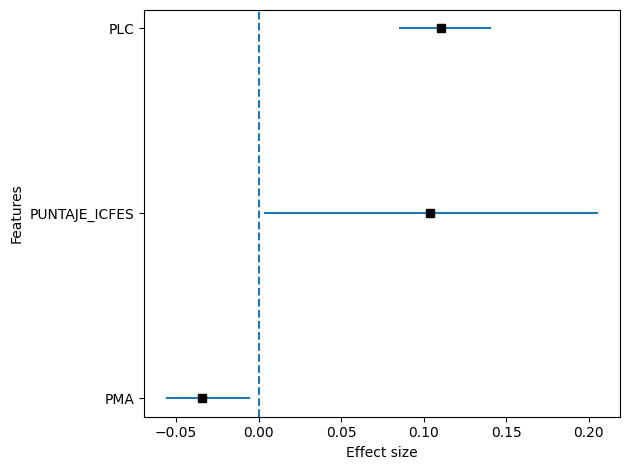

In [306]:
 # --------------------------------------------------------------------------------------------
effect_size_sig_df = effect_size_df.reindex(effect_size_df.mean().sort_values().index, axis=1)
lower_bound = np.percentile(effect_size_sig_df, 2.5, axis=0)
higher_bound = np.percentile(effect_size_sig_df, 97.5, axis=0)

for i, column in enumerate(effect_size_sig_df.columns):
    if (lower_bound[i] < 0) & (higher_bound[i] > 0):
        effect_size_sig_df = effect_size_sig_df.drop(columns=column)

n_regions = len(effect_size_sig_df.columns)

plt.figure()
plt.hlines(range(n_regions),
            np.percentile(effect_size_sig_df, 2.5, axis=0),
            np.percentile(effect_size_sig_df, 97.5, axis=0))

plt.plot(effect_size_sig_df.mean().values, range(n_regions), 's', color='k')
plt.axvline(0, ls='--')
plt.yticks(np.arange(n_regions), effect_size_sig_df.columns)
plt.xlabel('Effect size')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig(comparison_dir +'significant_features.png', format='png')
#plt.close()
#plt.clf()